In [2]:
! pip install seaborn==0.11.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.1/283.1 kB 6.3 MB/s eta 0:00:0000:01
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.12.2
    Uninstalling seaborn-0.12.2:
      Successfully uninstalled seaborn-0.12.2


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [11]:
import torch
from torch import nn
from torch.nn import functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset, Subset
from torch.utils.data.sampler import WeightedRandomSampler

import torchvision
from torchvision import datasets, models, transforms

In [5]:
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

In [6]:
import time
import os
import copy
from tqdm.autonotebook import tqdm, trange

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  after removing the cwd from sys.path.


In [7]:
from PIL import Image
from skimage import io

In [8]:
from pathlib import Path

In [9]:
import warnings
warnings.filterwarnings('ignore')

In [12]:
import random
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

Download data

In [13]:
augmentations = transforms.RandomChoice([
    transforms.RandomRotation(degrees=(-25, 25)),
    transforms.RandomHorizontalFlip(p=1),
    transforms.Compose([
        transforms.Resize(size=300),
        transforms.CenterCrop(size=300),
        transforms.RandomCrop(250)
    ])
])

In [14]:
train_transforms = transforms.Compose([
    augmentations,
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [15]:
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [16]:
TRAIN_DIR = '/kaggle/input/journey-springfield/train/simpsons_dataset'
TEST_DIR = '/kaggle/input/journey-springfield/testset/testset'

In [17]:
training_dataset = datasets.ImageFolder(root=TRAIN_DIR, transform=train_transforms)

In [18]:
str_data = [str(i) for i in training_dataset.targets]

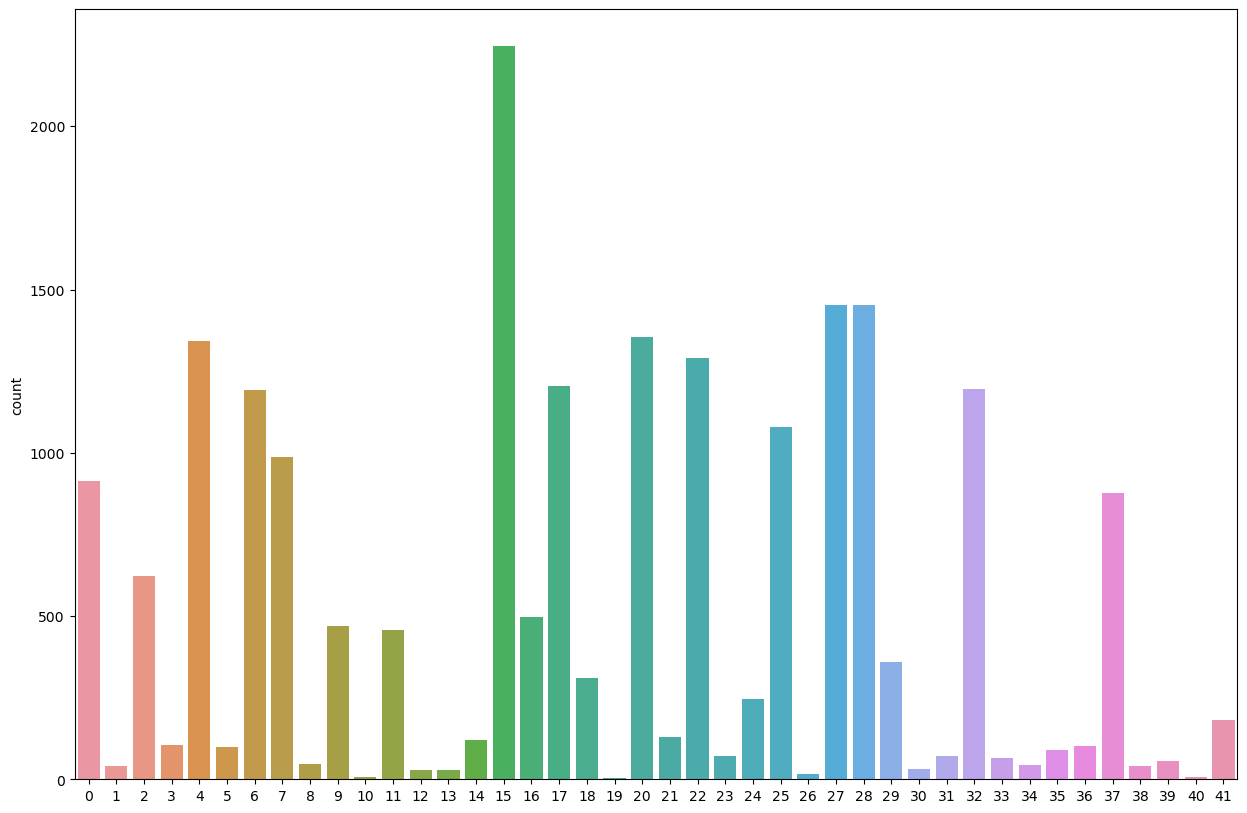

In [19]:
plt.figure(figsize=(15, 10))
sns.countplot(pd.Series(str_data).values)
plt.show()

We have deal with disbalanced classes

In [20]:
VAL_SIZE = 0.2
amount_train = len(training_dataset)
indices = list(range(amount_train))
split = int(np.floor(VAL_SIZE * amount_train))

np.random.shuffle(indices)

train_index, val_index = indices[split:] , indices[:split]

In [21]:
train_dataset = Subset(dataset=training_dataset, indices=train_index)
val_dataset = Subset(dataset=training_dataset, indices=val_index)

give weights to classes

In [22]:
from collections import Counter

In [23]:
class_count = Counter(training_dataset.targets[i] for i in train_index)

In [24]:
class_weights = {label: 1 / count for label, count in class_count.items()}
sample_weights = [0] * len(train_dataset)

for i, (data, label) in enumerate(tqdm(train_dataset)):
  weight = class_weights[label]
  sample_weights[i] = weight

n_max = max(class_count.values()) * len(class_count)
train_sampler = WeightedRandomSampler(sample_weights, num_samples=n_max, replacement=True)

  0%|          | 0/16747 [00:00<?, ?it/s]

In [25]:
BATCH_SIZE = 64

In [26]:
# data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [27]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

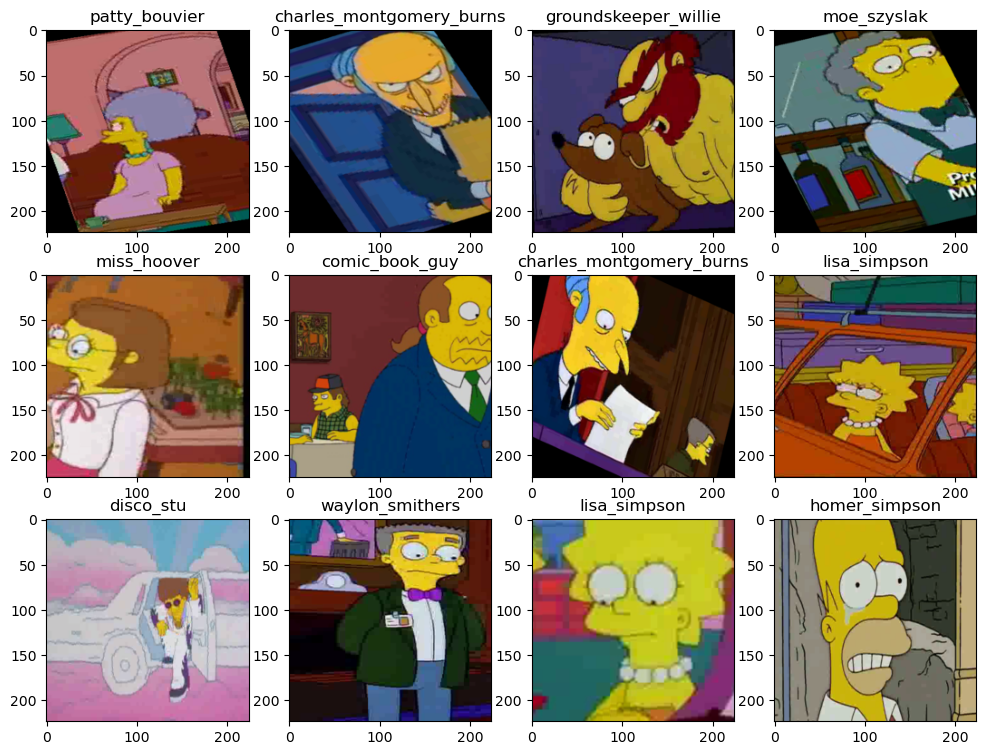

In [28]:
axes = plt.subplots(nrows=3, ncols=4, figsize=(12, 9))[1]
data, labels = next(iter(train_loader))
for ax, d, l in zip(axes.flatten(), data, labels):
    imshow(d.data.cpu(), title=training_dataset.classes[l], plt_ax=ax)

### Baseline

In [28]:
class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.out = nn.Linear(96 * 5 * 5, n_classes)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [29]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [30]:
model = SimpleCnn(42)
model = model.to(device)

### Train process

In [31]:
def fit_epoch(model, train_loader, criterion, optimizer, scheduler):
  model.train()
  running_loss = 0.0
  running_correct = 0
  processed_data = 0

  for inputs, labels in train_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()

    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    preds = torch.argmax(outputs, -1)
    running_loss += loss.item()
    running_correct += int(torch.sum(preds == labels.data))
    processed_data += inputs.size(0)

  scheduler.step()
  train_loss = running_loss / processed_data
  train_acc = running_correct / processed_data
  return train_loss, train_acc

In [30]:
def eval_epoch(model, val_loader, criterion):
  model.eval()
  running_loss = 0.0
  running_correct = 0
  processed_data = 0

  for inputs, labels in val_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad():
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      preds = torch.argmax(outputs, -1)

    running_loss += loss.item()
    running_correct += int(torch.sum(preds == labels.data))
    processed_data += inputs.size(0)

  val_loss = running_loss / processed_data
  val_acc = running_correct / processed_data

  torch.save(resnet_model.state_dict(), '/kaggle/working/resnet_weights.pth')

  return val_loss, val_acc

In [32]:
def train(model, loss, optimizer, scheduler, epochs, batch_size):
  history = []
  log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
  val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

  with tqdm(desc='epoch', total=epochs) as pbar_outer:
    for epoch in range(epochs):
      train_loss, train_acc = fit_epoch(model, train_loader, loss, optimizer, scheduler)
      print(f'Loss: {train_loss}')

      val_loss, val_acc = eval_epoch(model, val_loader, loss)
      history.append((train_loss, train_acc, val_loss, val_acc))

      pbar_outer.update(1)
      tqdm.write(
          log_template.format(
              ep=epoch+1, 
              t_loss=train_loss,
              v_loss=val_loss,
              t_acc=train_acc,
              v_acc=val_acc
              )
      )
  return history

In [33]:
def predict(model, test_loader):
  with torch.no_grad():
    logits = []

    for inputs in test_loader:
      inputs = inputs.to(device)
      model.eval()
      outputs = model(inputs).cpu()
      logits.append(outputs)

  probs = F.softmax(torch.cat(logits), dim=-1).numpy()
  return probs

In [40]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), amsgrad=True, lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.1)

In [45]:
history = train(
    model=model, 
    loss=loss, 
    optimizer=optimizer,
    scheduler=scheduler,
    epochs=20,
    batch_size=BATCH_SIZE
    )

epoch:   0%|          | 0/20 [00:00<?, ?it/s]

RuntimeError: ignored

### ResNet

In [34]:
resnet_model = models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [56]:
#for param in resnet_model.parameters():
#  param.requires_grad = False

In [35]:
num_feats = resnet_model.fc.in_features
resnet_model.fc = nn.Linear(num_feats, 42)

In [39]:
resnet_state_dict = torch.load('/kaggle/input/resnet-weights/resnet.pth')

In [40]:
resnet_model = resnet_model.to(device)

In [41]:
# предварительно обученный resnet, прошедший 4 эпохи обучения,
# такие же как представлены ниже
resnet_model.load_state_dict(resnet_state_dict)

<All keys matched successfully>

In [67]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet_model.parameters(), amsgrad=True, lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.1)

In [43]:
history = train(
    model=resnet_model, 
    loss=loss, 
    optimizer=optimizer,
    scheduler=scheduler,
    epochs=7,
    batch_size=BATCH_SIZE,
    )

epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Loss: 0.0017436417448650858

Epoch 001 train_loss: 0.0017   val_loss 0.0049 train_acc 0.9695 val_acc 0.9307
Loss: 0.001190880701256846

Epoch 002 train_loss: 0.0012   val_loss 0.0045 train_acc 0.9791 val_acc 0.9381
Loss: 0.0007924451790099852

Epoch 003 train_loss: 0.0008   val_loss 0.0035 train_acc 0.9865 val_acc 0.9505
Loss: 0.0005528298283904217

Epoch 004 train_loss: 0.0006   val_loss 0.0030 train_acc 0.9905 val_acc 0.9627
Loss: 0.0004361127062262344

Epoch 005 train_loss: 0.0004   val_loss 0.0034 train_acc 0.9922 val_acc 0.9568
Loss: 0.00036599124116081

Epoch 006 train_loss: 0.0004   val_loss 0.0031 train_acc 0.9931 val_acc 0.9603
Loss: 0.00032864719644977463

Epoch 007 train_loss: 0.0003   val_loss 0.0028 train_acc 0.9943 val_acc 0.9642


In [ ]:
# При большем количестве эпох начинается переобучение

In [53]:
torch.save(resnet_model.state_dict(), '/kaggle/working/resnet_weights.pth')

In [54]:
loss, acc, val_loss, val_acc = zip(*history)

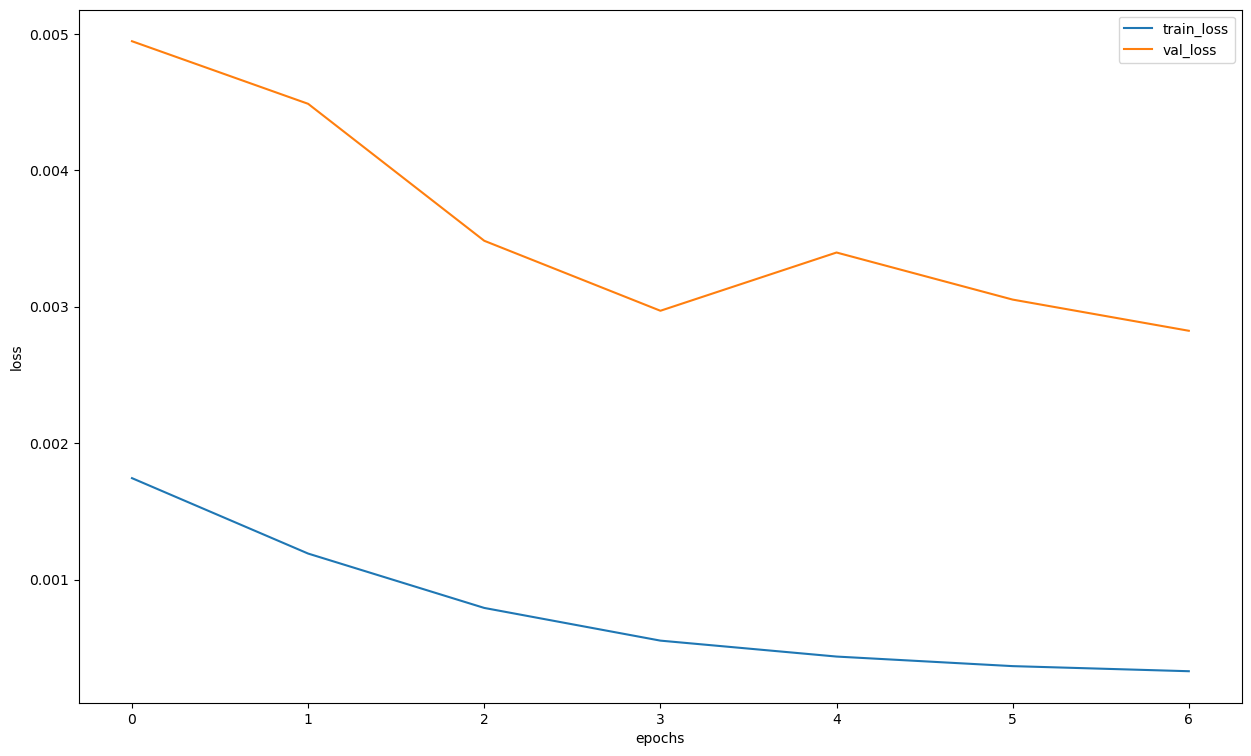

In [46]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

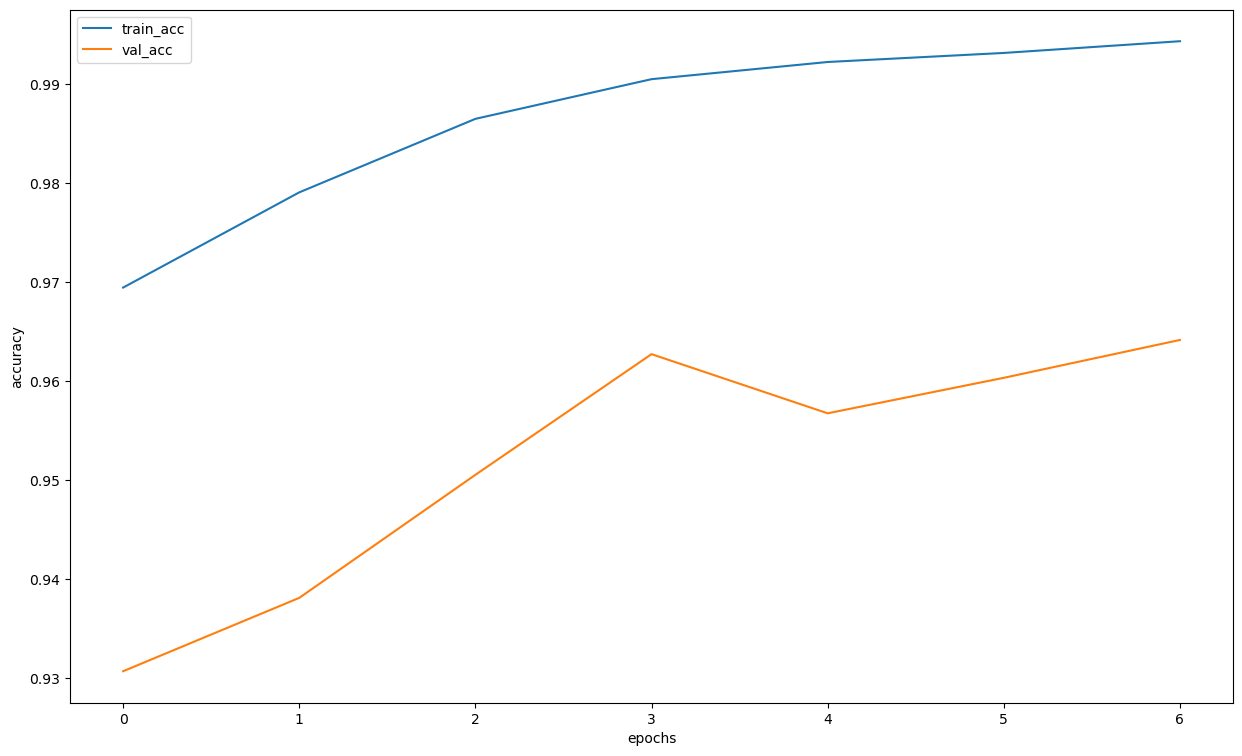

In [55]:
plt.figure(figsize=(15, 9))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

Predictions for test

In [69]:
class TestDataset(Dataset):

  def __init__(self, files):
    self.files = files

  def __getitem__(self, index):
    test_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    img = Image.open(self.files[index]).convert('RGB')
    return test_transforms(img)

  def __len__(self):
    return len(self.files)

In [70]:
test_dir = Path('/kaggle/input/journey-springfield/testset/testset')

In [71]:
test_files = sorted(list(test_dir.rglob('*.jpg')))

In [72]:
test_dataset = TestDataset(test_files)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=BATCH_SIZE)

In [73]:
probs = predict(resnet_model, test_loader)
preds = [training_dataset.classes[i] for i in probs.argmax(axis=-1)]

In [74]:
test_filenames = [path.name for path in test_dataset.files]

In [75]:
answers = pd.DataFrame({
    "Id": test_filenames,
    "Expected": preds
})
answers.head(10)

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon
5,img102.jpg,kent_brockman
6,img103.jpg,edna_krabappel
7,img104.jpg,chief_wiggum
8,img105.jpg,lisa_simpson
9,img106.jpg,kent_brockman


In [76]:
def get_number(name):
    return int(name[3:-4:])


answers['Num'] = answers['Id'].apply(get_number)
answers = answers.sort_values(by='Num', ignore_index=True).drop('Num', axis=1)
answers

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img2.jpg,mayor_quimby
3,img3.jpg,nelson_muntz
4,img4.jpg,lisa_simpson
...,...,...
986,img986.jpg,sideshow_bob
987,img987.jpg,nelson_muntz
988,img988.jpg,chief_wiggum
989,img989.jpg,charles_montgomery_burns


In [77]:
answers.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img2.jpg,mayor_quimby
3,img3.jpg,nelson_muntz
4,img4.jpg,lisa_simpson


In [78]:
answers.to_csv('/kaggle/working/simpson_classification.csv', index=False)

### Final score: Андрей_Шишков_130267589 - 0.98937